# Spotify Time Series Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
!{sys.executable} -m pip install --user numpy==1.19.3

In [ ]:
# Import the libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

## Loading the Data
Next, we are going to import the data.csv and convert it into a Pandas DataFrame.

In [5]:
# Import the data
data1 = pd.read_csv("/content/drive/MyDrive/Technocolab/data.csv")

# View the shape and columns names
print(data1.shape)
data1.columns

(169909, 19)


Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

The data contains plenty of songs with 19 different features columns. The features include the song name, artist, release date as well as some characteristics of the song such as acousticness, danceability, loudness, tempo and so on.

In [6]:
# Check for missing values
data1.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

The data1.isna().sum() method returns the number of missing values in each column. And as we can see, there is no missing value.

In [7]:
# Drop unneccessary columns
data1.drop(["id", "key", "mode", "explicit", "release_date"], axis=1, inplace=True)
data1.head()

,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,name,popularity,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0.563,0.1510,-12.428,Singende Bataillone 1. Teil,0,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0.901,0.0763,-28.454,"Fantasiestücke, Op. 111: Più tosto lento",0,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0.000,0.1190,-19.924,Chapter 1.18 - Zamek kaniowski,0,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0.887,0.1110,-14.734,Bebamos Juntos - Instrumental (Remasterizado),0,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0.908,0.0980,-16.829,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,0.0424,62.149,0.0693,1928


## Audio Features Correlation Analysis
Here we can observe correlations between various features.

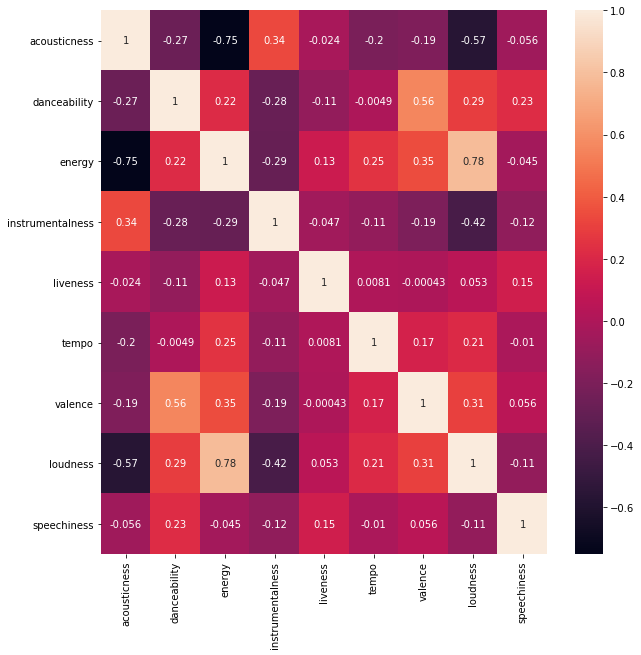

In [8]:
corr = data1[["acousticness","danceability","energy", "instrumentalness", 
           "liveness","tempo", "valence", "loudness", "speechiness"]].corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)

There is a strong positive correlation between energy and loudness as we suspected. On the other hand, there seems to be a strong negative correlation between energy and acousticness.

## Song Trends
The dataset contains songs from as far back as 1921. We can get an overview how the characteristics of song change over a hundred-year-period.

In [9]:
year_avg = data1[["acousticness","danceability","energy", "instrumentalness", 
               "liveness","tempo", "valence", "loudness", "speechiness", "year"]].\
groupby("year").mean().sort_values(by="year").reset_index()

year_avg.head()

,year,acousticness,danceability,energy,instrumentalness,liveness,tempo,valence,loudness,speechiness
0,1921,0.895823,0.425661,0.236784,0.322330,0.215814,100.397758,0.425495,-17.095438,0.077258
1,1922,0.939236,0.480000,0.237026,0.440470,0.238647,101.376139,0.534056,-19.179958,0.115419
2,1923,0.976329,0.568462,0.246936,0.401932,0.236656,112.456598,0.624788,-14.373882,0.098619
3,1924,0.935575,0.548654,0.347033,0.583955,0.237875,120.653359,0.668574,-14.202304,0.090210
4,1925,0.965422,0.571890,0.264373,0.408893,0.243094,115.671715,0.616430,-14.516707,0.115457


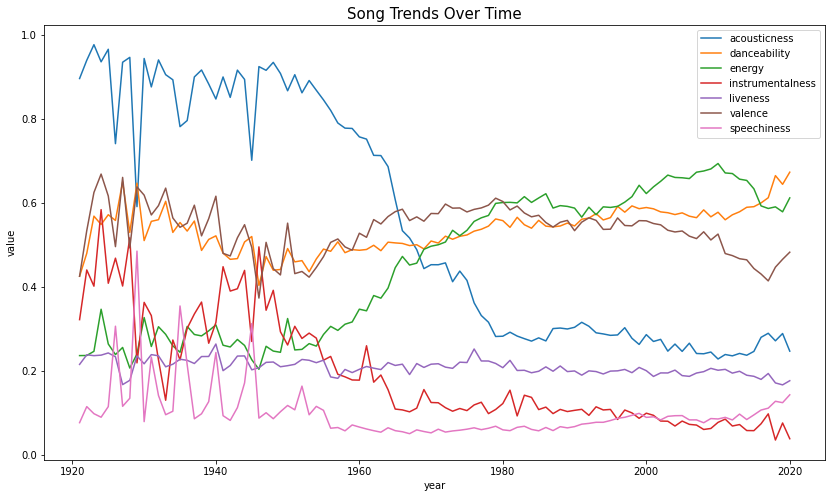

In [10]:
# Create a line plot
plt.figure(figsize=(14,8))
plt.title("Song Trends Over Time", fontdict={"fontsize": 15})

lines = ["acousticness","danceability","energy", 
         "instrumentalness", "liveness", "valence", "speechiness"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=year_avg)
    
    
plt.ylabel("value")
plt.legend(lines)

# Detecting Seasonality and removing it

In [11]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



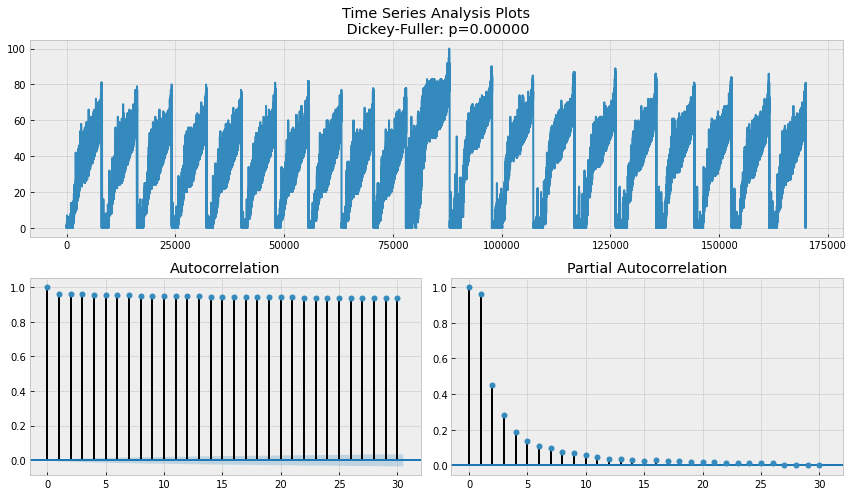

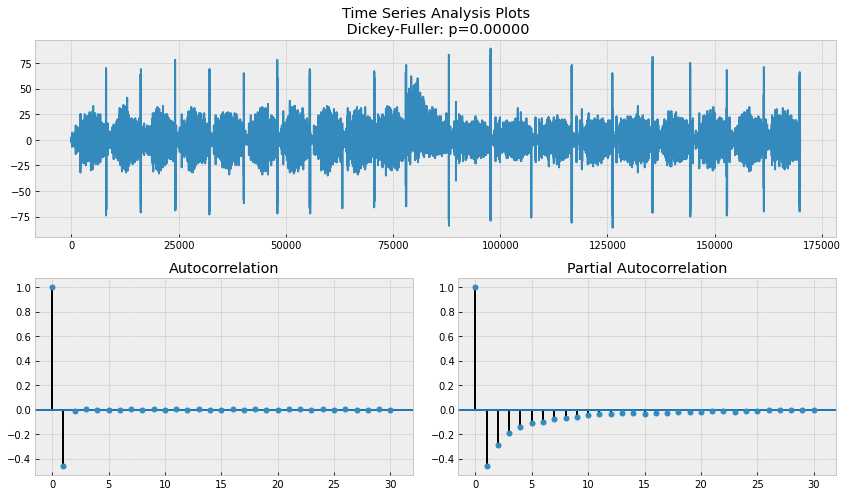

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data1["popularity"], lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data1["popularity"] - data1["popularity"].shift(1)

tsplot(data_diff[1:], lags=30)

## Artists with Most Songs


In [ ]:
# Check for the number of unique artists
data1["artists"].nunique()

33375

There are 33375 artists in the entire dataset.

In [ ]:
# Top 10 artists with most songs
data1["artists"].value_counts()[:10]

['Эрнест Хемингуэй']      1215
['Francisco Canaro']       938
['Эрих Мария Ремарк']      781
['Ignacio Corsini']        620
['Frank Sinatra']          592
['Bob Dylan']              539
['The Rolling Stones']     512
['Johnny Cash']            502
['The Beach Boys']         491
['Elvis Presley']          488
Name: artists, dtype: int64

Эрнест Хемингуэй has 1215 songs and the runner up, Francisco Canaro, has 938. 

In [ ]:
artist_list = data1.artists.value_counts().index[:10]

df_artists = data1[data1.artists.isin(artist_list)][["artists","year"]].\
groupby(["artists","year"]).size().reset_index(name="song_count")

df_artists.head()

,artists,year,song_count
0,['Bob Dylan'],1962,13
1,['Bob Dylan'],1963,73
2,['Bob Dylan'],1964,21
3,['Bob Dylan'],1965,66
4,['Bob Dylan'],1966,72


<AxesSubplot:xlabel='year', ylabel='song_count'>

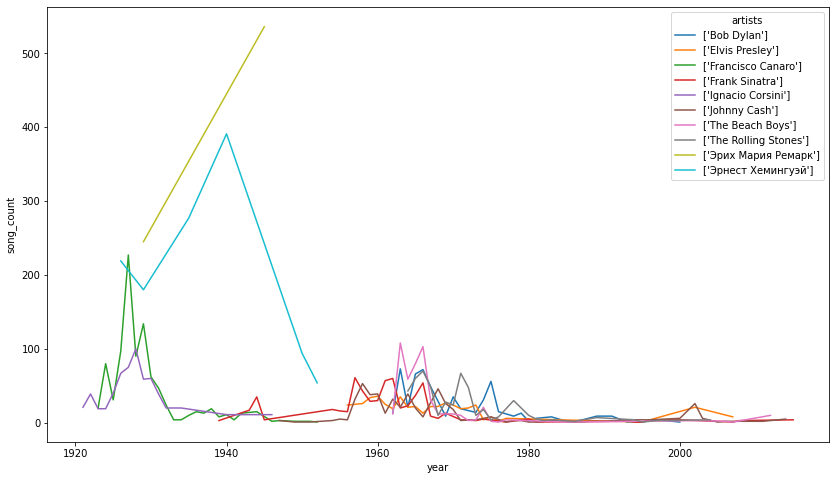

In [ ]:
plt.figure(figsize=(14,8))
sns.lineplot(x="year", y="song_count", hue="artists", data=df_artists)

AR MODEL

In [16]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'RSS: nan')

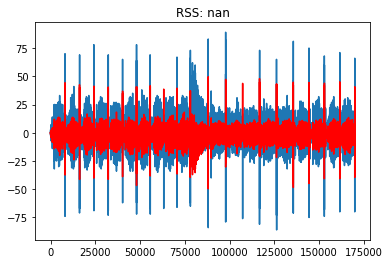

In [19]:
data1_pop = data1["popularity"]
model = ARIMA(data1_pop, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(data_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_diff)**2))

MA MODEL

Text(0.5, 1.0, 'RSS: nan')

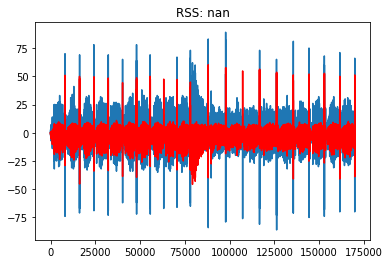

In [20]:
model = ARIMA(data1_pop, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(data_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-data_diff)**2))

Text(0.5, 1.0, 'RSS: nan')

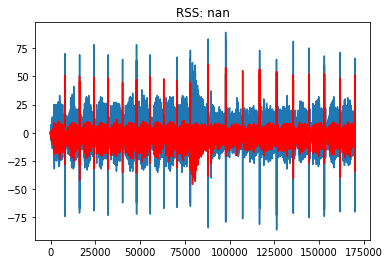

In [21]:
model = ARIMA(data1_pop, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(data_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-data_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. 